In [1]:
# %%writefile utils/my_utils.py

# Installation
# !python -m spacy download en_core_web_sm (# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER))
# !pip install scikit-learn
# !pip install textblob
# %pip install optuna (# Unlike !pip, %pip installs into the current Jupyter kernel's environment reliably)
# %pip install imblearn
# %pip install --upgrade optuna
# %pip install xgboost lightgbm
# %pip install shap

# Standard libraries
import os, io, datetime, sys, json
import shutil, subprocess, pathlib, shlex, platform
from tqdm import tqdm
import joblib
from pathlib import Path
import multiprocessing as mp

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Split to training and testing datasets
from sklearn.model_selection import train_test_split

# Feature scaling
from sklearn.preprocessing import PowerTransformer

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import (
    make_scorer, 
    roc_auc_score, 
    average_precision_score, 
    precision_score, 
    recall_score,
    fbeta_score,
)
from sklearn.base import clone
import sklearn
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import shap

#  Natural Language Processing (NLP)
import re, string
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Download

True

In [2]:
# Load in bulk

import pandas as pd
from pathlib import Path

# ── 1. Point to the folder that holds the 12 files ─────────────────────
root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"

# ── 2. List the file stems I saved earlier ───────────────────────────
stems = [
    "X_train_tfidf",  "X_test_tfidf",  "y_train_tfidf",  "y_test_tfidf",
    "X_train_cbert",  "X_test_cbert",  "y_train_cbert",  "y_test_cbert",
    "X_train_tfbert", "X_test_tfbert", "y_train_tfbert", "y_test_tfbert",
]

# ── 3. Bulk-load everything into a dict ────────────────────────────────
loaded = {
    stem: pd.read_csv(data_dir / f"{stem}.csv")
    for stem in stems
}

# ── 4. Convert the y_… DataFrames (single column) to 1-D Series ────────
for stem in stems:
    if stem.startswith("y_"):
        loaded[stem] = loaded[stem].squeeze("columns")

# ── 5. Optionally put them back into the notebook’s global namespace ──
globals().update(loaded)

# I can now use variables directly:
print(X_train_tfidf.shape, y_test_cbert.head())


(6544, 2005) 0    0
1    0
2    0
3    0
4    0
Name: readmit_30days, dtype: int64


# Best Logistic regression model with SMOTE only for Train

c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


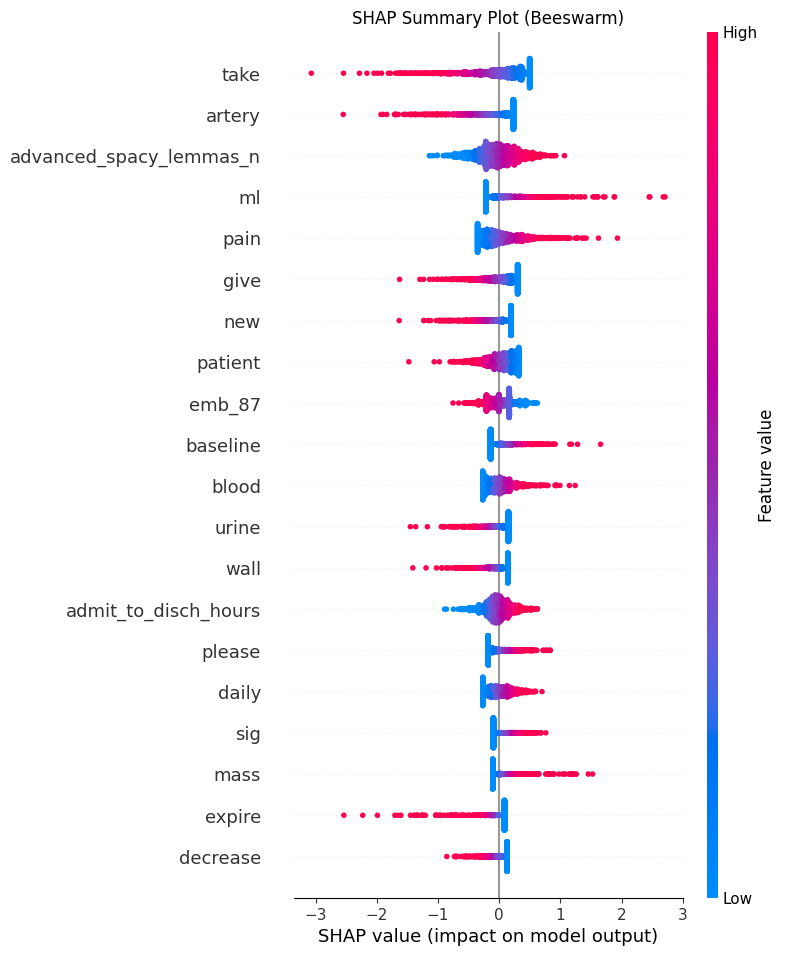

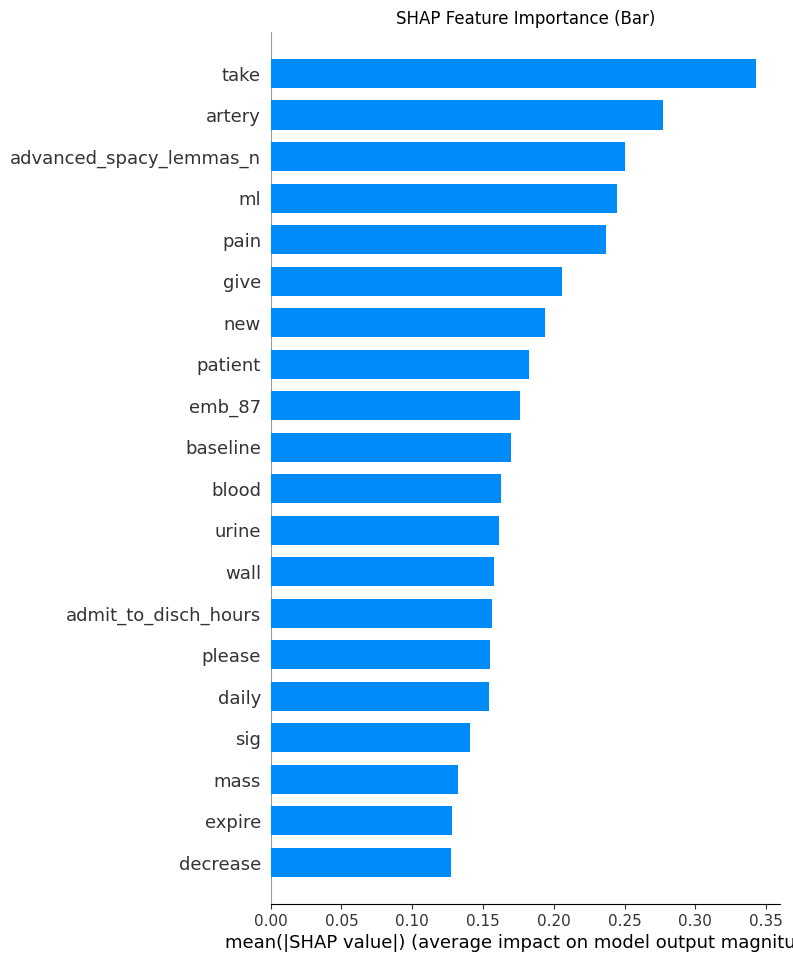

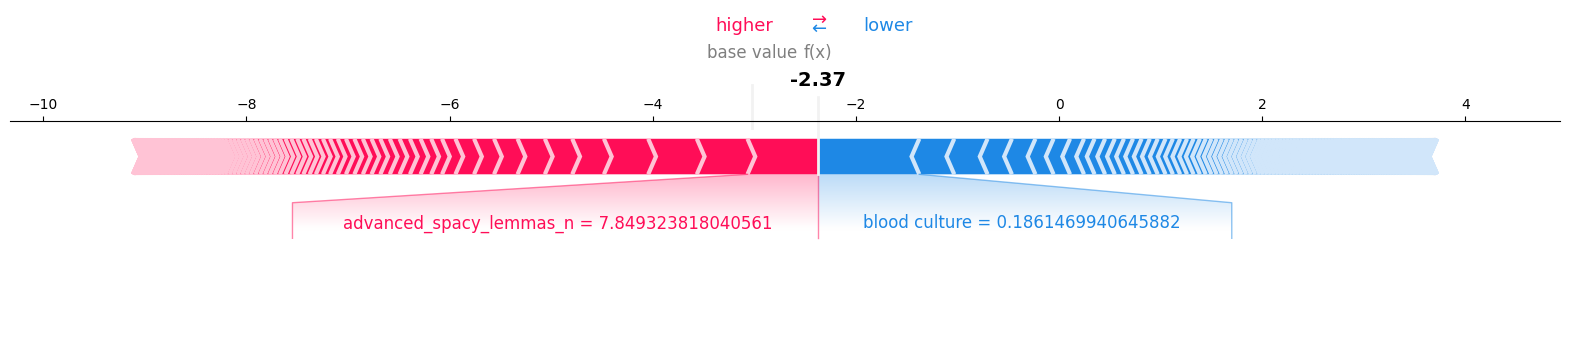

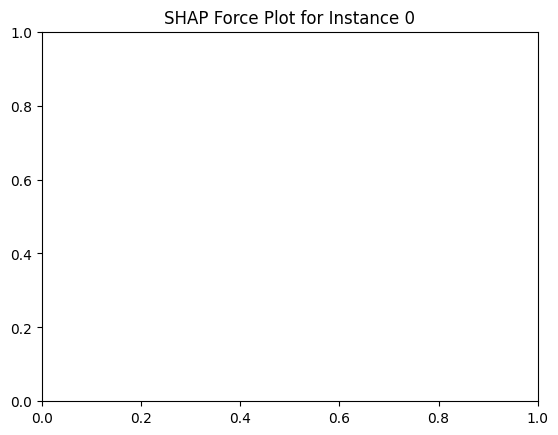

In [3]:
%matplotlib inline

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")


# Split a small test set for explanation (or use full train; adjust as needed)
X_train, X_explain, y_train, y_explain = train_test_split(
    X_train_tfbert, y_train_tfbert, test_size=0.2, stratify=y_train_tfbert, random_state=42
)

# Pipeline for fitting (SMOTE + LR)
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**best_lr_params)),
])

# Fit on train
pipe.fit(X_train, y_train)

# Extract the fitted LR model (SHAP explains the classifier, not the sampler)
lr_model = pipe.named_steps['clf']

# Prepare background data for SHAP (summary of training data; use a sample for efficiency)
# If data is sparse, convert to dense if needed; adjust sample size based on compute
background = shap.kmeans(X_train, 50).data  # Condensed summary (k=50 clusters)

# Use LinearExplainer for LogisticRegression (efficient for linear models)
explainer = shap.LinearExplainer(lr_model, background, feature_perturbation="interventional")

# Compute SHAP values on explain set (or a subset for speed)
shap_values = explainer.shap_values(X_explain)

# If multi-class or binary logistic, shap_values will be for positive class

# Visualizations

# 1. Summary plot (beeswarm: global feature importance)
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

# 2. Bar plot (mean absolute SHAP values for feature importance)
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.show()

# 3. Force plot for a single prediction (e.g., first instance)
# Adjust index as needed
instance_idx = 0
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()

# Optional: Dependence plot for a specific feature (replace 'feature_name' with actual)
# shap.dependence_plot('feature_name', shap_values, X_explain)

# Save SHAP values if needed
# shap_df = pd.DataFrame(shap_values, columns=X_explain.columns)
# shap_df.to_csv(saved_dir / f"shap_values_tfbert_logreg_{ts}.csv", index=False)

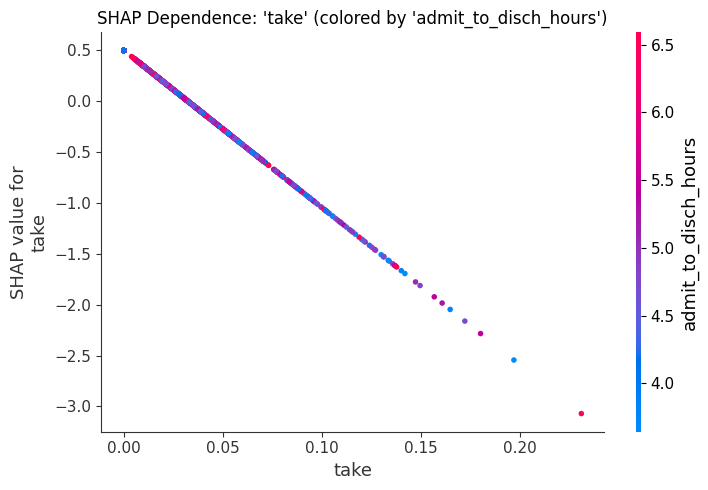

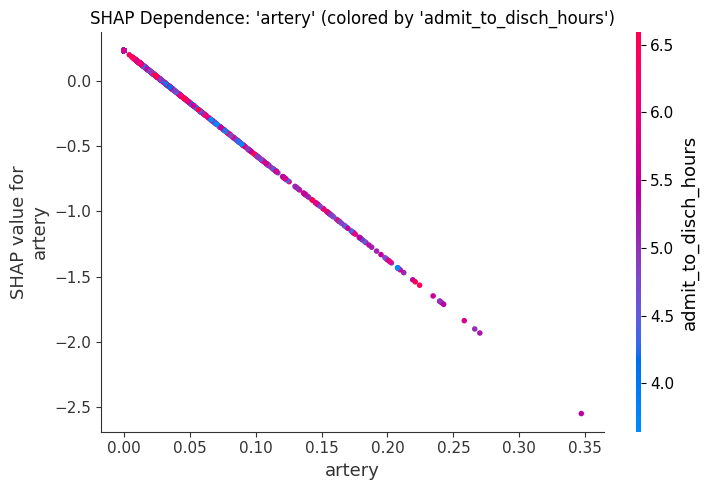

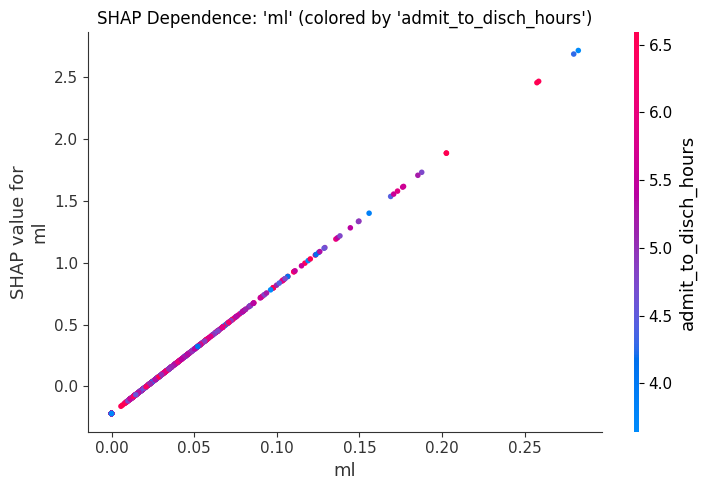

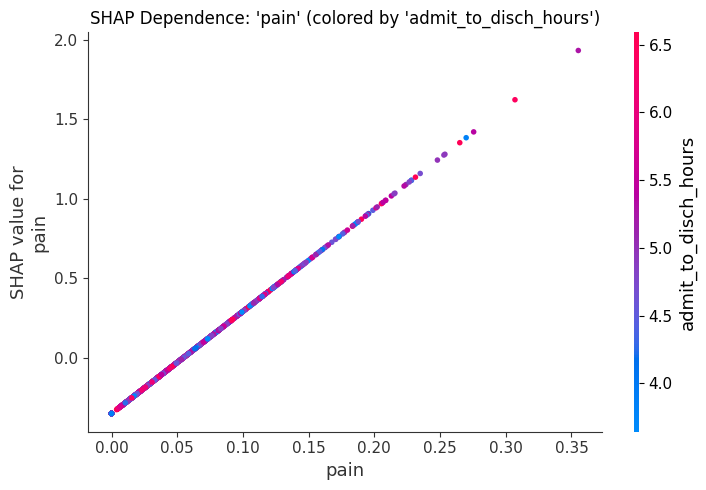

In [5]:
# ---- SHAP dependence plots for selected tokens ----
from pathlib import Path
import pandas as pd

features_to_plot = ["take", "artery", "ml", "pain"]

# Optional interaction feature (set to None to disable)
# If present, SHAP will color by this feature instead of the same one.
preferred_interaction = "admit_to_disch_hours"  # change or set to None

# Where to save (falls back to CWD if saved_dir isn't defined)
_out_dir = saved_dir if "saved_dir" in locals() else Path.cwd()
_ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

# Ensure X_explain is a DataFrame with column names
if not hasattr(X_explain, "columns"):
    raise ValueError("X_explain must be a pandas DataFrame with named columns.")

available = [f for f in features_to_plot if f in X_explain.columns]
missing   = [f for f in features_to_plot if f not in X_explain.columns]
if missing:
    print(f"[SHAP] Skipping missing features (not in X_explain columns): {missing}")

for feat in available:
    # Choose interaction index (if the preferred one exists)
    interaction_idx = preferred_interaction if preferred_interaction and preferred_interaction in X_explain.columns else None

    shap.dependence_plot(
        feat,
        shap_values,
        X_explain,
        interaction_index=interaction_idx,   # None → color by the same feature
        show=False
    )
    title_suffix = f" (colored by '{interaction_idx}')" if interaction_idx else ""
    plt.title(f"SHAP Dependence: '{feat}'{title_suffix}")
    plt.tight_layout()
    plt.savefig(_out_dir / f"shap_dependence_{feat}_{_ts}.png", dpi=300)
    plt.show()


# classification report and a confusion matrix

Using decision threshold = 0.50

Classification Report (%):


,precision,recall,f1-score,support (%)
0,99.11,94.68,96.84,99.01
1,2.82,15.38,4.76,0.99
accuracy,93.89,93.89,93.89,0.07
macro avg,50.96,55.03,50.80,100.00
weighted avg,98.16,93.89,95.93,100.00



Confusion Matrix (% of all samples):


Pred,0,1
True,,
0,93.74,5.27
1,0.84,0.15


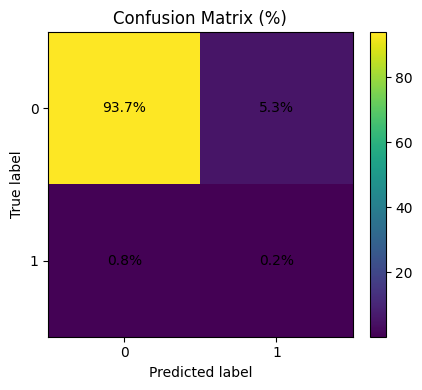

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----- Predict on the explain set -----
threshold = 0.50  # change if you want a different operating point
y_prob = pipe.predict_proba(X_explain)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

print(f"Using decision threshold = {threshold:.2f}")

# ----- Classification report (as percentages) -----
cr_dict = classification_report(y_explain, y_pred, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr_dict).transpose()

# Convert metrics to % and rename columns
for col in ["precision", "recall", "f1-score"]:
    if col in cr_df.columns:
        cr_df[col] = (cr_df[col] * 100.0)

# Convert support to % of total
n_total = len(y_explain)
if "support" in cr_df.columns and n_total > 0:
    cr_df["support (%)"] = (cr_df["support"] / n_total) * 100.0
    cr_df.drop(columns=["support"], inplace=True)

# Nice ordering and rounding
cols_order = [c for c in ["precision", "recall", "f1-score", "support (%)"] if c in cr_df.columns]
cr_df = cr_df.loc[["0", "1", "accuracy", "macro avg", "weighted avg"], cols_order].round(2)
print("\nClassification Report (%):")
display(cr_df)

# ----- Confusion matrix (as % of all samples) -----
labels = [0, 1]
cm = confusion_matrix(y_explain, y_pred, labels=labels)
cm_pct = (cm / cm.sum()) * 100.0

cm_df = pd.DataFrame(
    cm_pct,
    index=pd.Index(labels, name="True"),
    columns=pd.Index(labels, name="Pred")
).round(2)

print("\nConfusion Matrix (% of all samples):")
display(cm_df)

# ----- Heatmap -----
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_pct)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (%)")

# Annotate each cell with %
for i in range(cm_pct.shape[0]):
    for j in range(cm_pct.shape[1]):
        ax.text(j, i, f"{cm_pct[i, j]:.1f}%", ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


# Linking top tokens back to their original contexts to make SHAP story

Below is a drop‑in workflow that:

- finds rows where a token (e.g., 'take', 'artery') appears,
- ranks those rows by that token’s SHAP contribution (most negative/positive),
- extracts short text snippets around the token from the original note, and
- computes simple presence stats (readmission rate with/without the token and the LR coefficient sign).

In [12]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

tfidf_1to1_dropped_1 = pd.read_csv(data_dir / "tfidf_1to1_dropped_1.csv")
clinbert_1to1_dropped_1 = pd.read_csv(data_dir / "clinbert_1to1_dropped_1.csv")
tfidf_clinbert_1to1_dropped_1 = pd.read_csv(data_dir / "tfidf_clinbert_1to1_dropped_1.csv")
tfidf_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_1to1_dropped_2.csv")
clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "clinbert_1to1_dropped_2.csv")
tfidf_clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_clinbert_1to1_dropped_2.csv")

C:\Users\Sheng Miao\AppData\Local\Temp\ipykernel_71368\1161012343.py:9: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  tfidf_clinbert_1to1_dropped_1 = pd.read_csv(data_dir / "tfidf_clinbert_1to1_dropped_1.csv")


In [11]:
print(tfidf_clinbert_1to1_dropped_2.columns)

Index(['length_of_icu_stay_hours', 'admit_to_disch_hours', 'readmit_30days',
       'note_length', 'word_count', 'advanced_spacy_lemmas_n', 'ab', 'abd',
       'abd soft', 'abdomen',
       ...
       'emb_758', 'emb_759', 'emb_760', 'emb_761', 'emb_762', 'emb_763',
       'emb_764', 'emb_765', 'emb_766', 'emb_767'],
      dtype='object', length=2774)


In [15]:
%matplotlib inline

import re, numpy as np, pandas as pd

# ────────────────────── CONFIG ──────────────────────
TOKENS   = ['take', 'artery']         # edit as needed
TEXT_COL = 'text'                # <-- set to your raw-text column in tfidf_clinbert_1to1_dropped_1
SHAP_VALUES = shap_values             # array-like, aligned to X_explain (n_samples × n_features)
MODEL = lr_model                      # fitted LogisticRegression on the same columns as X_explain
# ────────────────────────────────────────────────────

# Safety: ensure NumPy array for SHAP values
SV = SHAP_VALUES.values if hasattr(SHAP_VALUES, "values") else np.asarray(SHAP_VALUES)
assert SV.shape[0] == X_explain.shape[0], "shap_values must align with X_explain rows."

# Helper: find TF-IDF feature columns that correspond to a token
def find_token_cols(columns, token:str):
    cols = [str(c) for c in columns]
    t = re.escape(token.lower())
    # Try common patterns first (exact, tfidf__token, word-boundary matches), then fallback to substring
    pat = re.compile(rf'(?:^|__|\b){t}(?:\b|$)')
    cand = [c for c in cols if pat.search(c.lower())]
    if not cand:
        cand = [c for c in cols if c.lower() == token.lower()]
    if not cand:
        cand = [c for c in cols if token.lower() in c.lower()]  # last-resort substring
    return cand

# Helper: extract a short snippet around the first occurrence of token (case-insensitive)
def snippet_around(text, token, window=60):
    txt = "" if pd.isna(text) else str(text)
    m = re.search(re.escape(token), txt, flags=re.IGNORECASE)
    if not m:
        return ""
    start = max(0, m.start() - window)
    end   = min(len(txt), m.end() + window)
    snip = txt[start:end]
    # highlight token
    return re.sub(re.escape(token), lambda m:f"[{m.group(0).upper()}]", snip, flags=re.IGNORECASE)

# We’ll work on the explanation split and map back to original rows via index alignment
orig_text_series = tfidf_clinbert_1to1_dropped_1.loc[X_explain.index, TEXT_COL]
y_exp = pd.Series(y_explain.values, index=X_explain.index, name='readmit_30days')

# Precompute model probabilities on X_explain (optional but handy)
proba_exp = pd.Series(MODEL.predict_proba(X_explain)[:, 1], index=X_explain.index, name='proba')

results = {}  # token -> dict of outputs

for token in TOKENS:
    token_cols = find_token_cols(X_explain.columns, token)
    if not token_cols:
        print(f"[WARN] No feature columns matched token '{token}'. Skipping.")
        continue

    # Presence mask: any of the token's columns has a positive TF-IDF value
    present_mask = (X_explain[token_cols].sum(axis=1) > 0)

    # SHAP contribution for the token = sum across its matched columns
    col_idx = [X_explain.columns.get_loc(c) for c in token_cols]
    shap_token = SV[:, col_idx].sum(axis=1) if len(col_idx) > 1 else SV[:, col_idx[0]]
    shap_token = pd.Series(shap_token, index=X_explain.index, name='shap_token')

    # LR coefficient sign (sum across matched token columns)
    coef_sum = float(np.sum(MODEL.coef_[0, col_idx]))
    coef_sign = "positive" if coef_sum > 0 else ("negative" if coef_sum < 0 else "zero")

    # Build a dataframe for ranking and display
    df_tok = pd.concat([y_exp, proba_exp, shap_token], axis=1)
    df_tok['present'] = present_mask

    # Attach a snippet for rows where token is present
    snips = orig_text_series[present_mask].apply(lambda t: snippet_around(t, token, window=60))
    df_tok.loc[present_mask, 'snippet'] = snips

    # Rankings: most positive and most negative SHAP contributions among rows where token is present
    top_pos = df_tok[df_tok['present']].sort_values('shap_token', ascending=False).head(15)
    top_neg = df_tok[df_tok['present']].sort_values('shap_token', ascending=True ).head(15)

    # Presence stats
    n_present = int(present_mask.sum())
    n_absent  = int((~present_mask).sum())
    rate_present = float(y_exp[present_mask].mean()) if n_present > 0 else np.nan
    rate_absent  = float(y_exp[~present_mask].mean()) if n_absent  > 0 else np.nan
